In [2]:
!pip install nlp

     |████████████████████████████████| 1.7MB 10.8MB/s 
     |████████████████████████████████| 245kB 54.8MB/s 


In [16]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


In [4]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
tweets[0]

'i didnt feel humiliated'

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

<function matplotlib.pyplot.show>

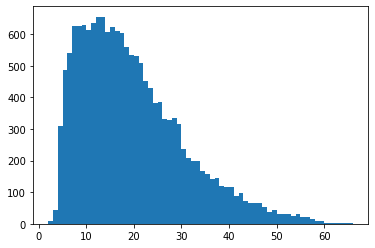

In [120]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show

In [25]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [70]:
def get_sequences(tokenizer, tweets):
  # making all sequences same length
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen)
  return padded

In [71]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [72]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [73]:
classes = set(labels)
print(classes)

{'joy', 'sadness', 'fear', 'surprise', 'love', 'anger'}


In [74]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [75]:
class_to_index

{'anger': 5, 'fear': 2, 'joy': 0, 'love': 4, 'sadness': 1, 'surprise': 3}

In [76]:
index_to_class

{0: 'joy', 1: 'sadness', 2: 'fear', 3: 'surprise', 4: 'love', 5: 'anger'}

In [33]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [34]:
train_labels = names_to_ids(labels)
train_labels[0]

1

In [70]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [74]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels= names_to_ids(val_labels)

In [75]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [179]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1018 - accuracy: 0.9661 - val_loss: 0.4007 - val_accuracy: 0.8860
Epoch 2/20
500/500 [==============================] - 20s 40ms/step - loss: 0.0750 - accuracy: 0.9746 - val_loss: 0.4525 - val_accuracy: 0.8845
Epoch 3/20
500/500 [==============================] - 20s 40ms/step - loss: 0.0629 - accuracy: 0.9795 - val_loss: 0.4368 - val_accuracy: 0.8940
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 0.0548 - accuracy: 0.9818 - val_loss: 0.4377 - val_accuracy: 0.8970
Epoch 5/20
500/500 [==============================] - 20s 39ms/step - loss: 0.0507 - accuracy: 0.9841 - val_loss: 0.4447 - val_accuracy: 0.8950
Epoch 6/20
500/500 [==============================] - 20s 39ms/step - loss: 0.0440 - accuracy: 0.9861 - val_loss: 0.4592 - val_accuracy: 0.8960
Epoch 7/20
500/500 [==============================] - 20s 40ms/step - loss: 0.0431 - accuracy: 0.9858 - val_loss: 0.4423 - val_accuracy:

In [78]:
test_tweets, test_labels=get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels=names_to_ids(test_labels)

In [180]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.5289 - accuracy: 0.8865


[0.5289077758789062, 0.8865000009536743]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


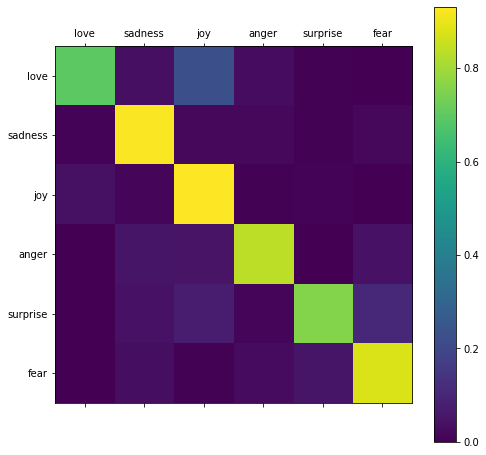

In [185]:
preds = model.predict_classes(test_seq)
show_confusion_matrix(test_labels, preds, list(classes))

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [196]:
model.save("/content/drive/My Drive/TweetEmotionRecognition/h5/tweet_model.h5")

In [103]:
# model.save("/content/drive/My Drive/TweetEmotionRecognition/model/")

INFO:tensorflow:Assets written to: /content/drive/My Drive/TweetEmotionRecognition/model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/TweetEmotionRecognition/model/assets


In [184]:
i = random.randint(0,len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
print(test_seq[i])
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence: i will try and stay focused in order to avoid that feeling of a reluctant finish
Emotion: fear
[   2   59  204    4  575 1585   12  758    5 1416    9    8   10    7
  539  935    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Predicted Emotion:  fear


In [201]:
sequence = tokenizer.texts_to_sequences(["i am angry"])
paddedSequence = pad_sequences(sequence, truncating = 'post', padding='post', maxlen=maxlen)
p = model.predict(np.expand_dims(paddedSequence[0], axis=0))[0]
print(paddedSequence[0])
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)
print(p)
print(index_to_class)

[  2  24 264   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Predicted Emotion:  anger
[0.00389229 0.01410565 0.00155318 0.9459983  0.02512505 0.00932543]
{0: 'love', 1: 'sadness', 2: 'joy', 3: 'anger', 4: 'surprise', 5: 'fear'}


In [18]:
load_model = tf.keras.models.load_model("/content/drive/My Drive/TweetEmotionRecognition/h5/tweet_model.h5")
print(load_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________
None


In [87]:
sentence = 'i am not sure what to do'
sequence = tokenizer.texts_to_sequences([sentence])
paddedSequence = pad_sequences(sequence, truncating = 'post', padding='post', maxlen=maxlen)
p = load_model.predict(np.expand_dims(paddedSequence[0], axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('Sentence:', sentence)
print('Predicted Emotion: ', pred_class)

Sentence: i am not sure what to do
Predicted Emotion:  fear
